<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/master/notebooks/1b_retropropagacion_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retropropagación de errores

En este *notebook* programaremos con PyTorch una red neuronal densa y la entrenaremos para aproximar la operación XOR usando del gradiente descedente con el algoritmo de retropropagación de errores. Recordemos que la operación XOR ($\otimes$) está de la siguiente manera:

| $x_1$ | $x_2$ | $y$
| ------------- |:-------------:| -----:|
|0 |0 |0|
|0 |1 |1|
|1 |0 |1|
|1 |1 |0|


In [13]:
import torch
import math

Nuestra red neuronal densa está compuesta por una capa de 2 entradas ($x_1$ y $x_2$), una capa oculta con 10 neuronas con función de activación sigmoide y una capa de salida con una sola neurona con función de activación sigmoide. Esta función de activación se define como:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

In [14]:
def sigmoide(z):
    return 1 / (1 + torch.exp(-z))

La función sigmoide tiene una derivada que está expresada en términos de la misma función, esto es, 

$$
\frac{\partial \sigma (z)}{\partial z} = \sigma(z) (1 - \sigma(z))
$$

In [15]:
def derivada_sigmoide(x):
    s = sigmoide(x)
    return s * (1.0 - s)

Podemos ver la operación XOR como una tarea de clasificación binaria a partir de 2 entradas. Por lo tanto, usaremos la función de pérdida de entropía cruzada binaria:

$$
ECB(\mathbf{y}, \mathbf{\hat{y}})  = -\sum_{i=1}^N \left[ y^{(i)} \log \hat{y}^{(i)} + (1 - y^{(i)}) \log (1 - \hat{y}^{(i)}) \right]
$$

In [16]:
def entropia_cruzada_binaria(y, p):
    return -(torch.log(p[y == 1]).sum() + torch.log(1 - p[y == 0]).sum())

Asimismo, calcularemos la exactitud para medir el rendimiento del modelo aprendido por la red neuronal densa:

$$
exactitud = \frac{correctos}{total}
$$

In [17]:
def exactitud(y, y_predicha):
    return (y == y_predicha).float().mean() * 100

Ahora, definimos la función que propaga hacia adelante una entrada $\mathbf{x}^{i}$. Como la red está compuesta de 2 capas densas (1 oculta y 1 de salida), tenemos 2 matrices de pesos con sus correspondientes vectores de sesgos $\{\mathbf{W}^{\{1\}}, \mathbf{b}^{\{1\}}\}$ y $\{\mathbf{W}^{\{2\}}, \mathbf{b}^{\{2\}}\}$ de la capa oculta y la capa de salida respectivamente. Así, podemos llevar a cabo la propagación hacia adelante en esta red de la siguiente manera:

$$
	\begin{split}
				\mathbf{a}^{\{1\}} & =  \mathbf{x}^{(i)} \\
				\mathbf{z}^{\{2\}} & =  \mathbf{W}^{\{1\}} \cdot \mathbf{a}^{\{1\}} + \mathbf{b}^{\{1\}}\\
				\mathbf{a}^{\{2\}} & =  \sigma(\mathbf{z}^{\{2\}}) \\
				\mathbf{z}^{\{3\}} & =  \mathbf{W}^{\{2\}} \cdot \mathbf{a}^{\{2\}}  + \mathbf{b}^{\{2\}}\\
				\mathbf{a}^{\{3\}} & =  \sigma(\mathbf{z}^{\{3\}})\\
				\hat{y}^{(i)} & =  \mathbf{a}^{\{3\}}
			\end{split}
      $$

In [18]:
def hacia_adelante(x, W1, b1, W2, b2):
    z2 = W1.t() @ x + b1
    a2 = sigmoide(z2)
    z3 = W2.t() @ a2 + b2
    y_hat = sigmoide(z3)
  
    return z2, a2, z3, y_hat

Finalmente, definimos la función para entrenar nuestra red neuronal usando gradiente descendente. Para calcular el gradiente de la función de pérdida respecto a los pesos y sesgos en cada capa empleamos el algoritmo de retropropagación de errores.



In [19]:
def retropropagacion(X, y, alpha = 0.01, n_epocas = 100, n_ocultas = 10):
    n_ejemplos, n_entradas = X.shape
    
    # Inicialización de las matrices de pesos W y V
    W1 = math.sqrt(1.0 / n_entradas) * torch.randn(n_entradas, n_ocultas)
    b1 = torch.zeros(n_ocultas)
    
    W2 = math.sqrt(1.0 / n_ocultas) * torch.randn(n_ocultas)
    b2 = torch.zeros(1)
    
    perdidas = torch.zeros(n_epocas)
    exactitudes = torch.zeros(n_epocas)
    y_predicha = torch.zeros(y.shape)
    for i in range(n_epocas):
        for j in range(n_ejemplos):
            z2, a2, z3, y_hat = hacia_adelante(X[j], W1, b1, W2, b2)

            # cálculo de gradiente para W2 por retropropagación
            delta3 = (y_hat - y[j]) * derivada_sigmoide(z3)
            W2 -= alpha * a2 * delta3
            b2 -= alpha * delta3

            # cálculo de gradiente para W1 por retropropagación
            delta2 = W2 * delta3 * derivada_sigmoide(z2)
            W1 -= alpha * torch.ger(X[j], delta2)
            b1 -= alpha * delta2

            y_predicha[j] = y_hat
            
        # calcula error en época
        perdidas[i] = entropia_cruzada_binaria(y, y_predicha)
        exactitudes[i] = exactitud(y, torch.round(y_predicha))
        if (i+1) % 20 == 0:
            print(f'Epoch {i+1}: Error = {perdidas[i]} Exactitud = {exactitudes[i]}')

    return W1, W2, perdidas, exactitudes

Para probar nuestra red, generamos los ejemplos correspondientes a la operación XOR.

In [20]:
# ejemplo (XOR)
X = torch.tensor([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
y = torch.tensor([0., 1., 1., 0.])

Finalmente, entrenamos nuestra red con estos ejemplos por 200 épocas usando una tasa de aprendizaje $\alpha = 1.0$.

In [21]:
torch.manual_seed(0)
W1, W2, perdidas, exactitudes = retropropagacion(X, 
                                                 y, 
                                                 alpha = 1.0, 
                                                 n_epocas = 300,
                                                 n_ocultas = 10)

Epoch 20: Error = 3.4514527320861816 Exactitud = 50.0
Epoch 40: Error = 3.483663320541382 Exactitud = 50.0
Epoch 60: Error = 3.5026187896728516 Exactitud = 50.0
Epoch 80: Error = 3.4997472763061523 Exactitud = 50.0
Epoch 100: Error = 3.4624674320220947 Exactitud = 50.0
Epoch 120: Error = 3.372633934020996 Exactitud = 50.0
Epoch 140: Error = 3.2141807079315186 Exactitud = 50.0
Epoch 160: Error = 2.993985891342163 Exactitud = 50.0
Epoch 180: Error = 2.748088836669922 Exactitud = 75.0
Epoch 200: Error = 2.48521089553833 Exactitud = 75.0
Epoch 220: Error = 2.1526074409484863 Exactitud = 75.0
Epoch 240: Error = 1.7091784477233887 Exactitud = 100.0
Epoch 260: Error = 1.2717576026916504 Exactitud = 100.0
Epoch 280: Error = 0.9692773222923279 Exactitud = 100.0
Epoch 300: Error = 0.7800878286361694 Exactitud = 100.0


Graficamos el valor de la pérdida y la exactitud en cada época para ver el comportamiento de nuestra red durante el entrenamiento:

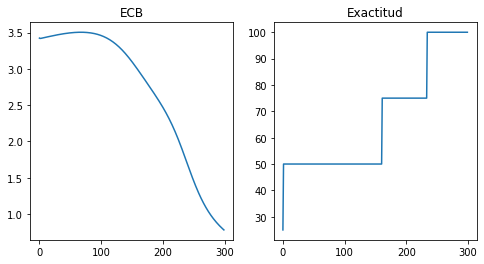

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

ax[0].plot(perdidas.numpy())
ax[0].set_title('ECB')
ax[1].plot(exactitudes.numpy())
ax[1].set_title('Exactitud');

## Inicializando los pesos con zeros
Como se mencionó anteriormente, las matrices de pesos $\mathbf{W^{\{1\}}}$ y $\mathbf{W^{\{2\}}}$ se initializan con valores aleatorios pequeños mientras que los vectores de sesgo $\mathbf{b^{\{1\}}}$ y $\mathbf{b^{\{1\}}}$ con zeros. Examinemos qué pasa si inicializamos las matrices de pesos con zeros. Observa los valores de los pesos en cada época.

In [23]:
def retropropagacion_zeros(X, y, alpha = 0.1, n_epocas = 100, n_ocultas = 10):
    n_ejemplos, n_entradas = X.shape
    
    # Inicializa matrices de pesos W1 y W2 y vectores de sesgos b1 y b2
    W1 = torch.zeros(n_entradas, n_ocultas)
    b1 = torch.zeros(n_ocultas) 
    W2 = torch.zeros(n_ocultas)
    b2 = torch.zeros(1)
    
    perdidas = torch.zeros(n_epocas)
    exactitudes = torch.zeros(n_epocas)
    y_predicha = torch.zeros(y.shape)
    for i in range(n_epocas):
        for j in range(n_ejemplos):
            z2, a2, z3, y_hat = hacia_adelante(X[j], W1, b1, W2, b2)

            # cálculo de gradiente para W2 por retropropagación
            delta3 = (y_hat - y[j]) * derivada_sigmoide(z3)
            W2 -= alpha * a2 * delta3
            b2 -= alpha * delta3

            # cálculo de gradiente para W1 por retropropagación
            delta2 = W2 * delta3 * derivada_sigmoide(z2)
            W1 -= alpha * torch.ger(X[j], delta2)
            b1 -= alpha * delta2

            y_predicha[j] = y_hat
            
        # calcula error en época
        perdidas[i] = entropia_cruzada_binaria(y, y_predicha)
        exactitudes[i] = exactitud(y, torch.round(y_predicha))
        print(f'Epoch {i+1}: Error = {perdidas[i]} Exactitud = {exactitudes[i]}')
        print('W1 = {0}'.format(W1.numpy()))
        print('W2 = {0}'.format(W2.numpy()))
            
    return W1, W2, perdidas, exactitudes

In [24]:
W1, W2, perdidas, exactitudes = retropropagacion_zeros(X, 
                                                       y, 
                                                       alpha = 1.0,
                                                       n_epocas = 5,
                                                       n_ocultas = 10)

Epoch 1: Error = 3.257566452026367 Exactitud = 50.0
W1 = [[0.00222783 0.00222783 0.00222783 0.00222783 0.00222783 0.00222783
  0.00222783 0.00222783 0.00222783 0.00222783]
 [0.00047238 0.00047238 0.00047238 0.00047238 0.00047238 0.00047238
  0.00047238 0.00047238 0.00047238 0.00047238]]
W2 = [-0.00300507 -0.00300507 -0.00300507 -0.00300507 -0.00300507 -0.00300507
 -0.00300507 -0.00300507 -0.00300507 -0.00300507]
Epoch 2: Error = 3.2594382762908936 Exactitud = 50.0
W1 = [[0.00448687 0.00448687 0.00448687 0.00448687 0.00448687 0.00448687
  0.00448687 0.00448687 0.00448687 0.00448687]
 [0.00092736 0.00092736 0.00092736 0.00092736 0.00092736 0.00092736
  0.00092736 0.00092736 0.00092736 0.00092736]]
W2 = [-0.00457636 -0.00457636 -0.00457636 -0.00457636 -0.00457636 -0.00457636
 -0.00457636 -0.00457636 -0.00457636 -0.00457636]
Epoch 3: Error = 3.2615671157836914 Exactitud = 50.0
W1 = [[0.00676583 0.00676583 0.00676583 0.00676583 0.00676583 0.00676583
  0.00676583 0.00676583 0.00676583 0.0067

## Tarea
Modifica el código anterior para agregar una capa extra de neuronas ocultas.
